<a href="https://colab.research.google.com/github/google/neural-tangents/blob/master/notebooks/neural_tangents_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports and Utils

In [0]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [0]:
import jax.numpy as np

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools




  import neural_tangents as nt
from neural_tangents import stax

In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')
sns.set(font_scale=1.3)

def format_plot(x=None, y=None): 
  plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

In [0]:
def plot_function(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')
  
  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

# Neural Tangents Cookbook

In this notebook we explore the training of infinitely-wide, Bayesian, neural networks using a library called [Neural Tangents](https://github.com/google/neural-tangents). Recent work has shown that such networks are Gaussian Processes with a particular compositional kernel called the NNGP kernel. More recently, it was shown that predictions resulting from these networks following Gradient Descent are Gaussian with a distribution that can be computed in closed form using the [Neural Tangent Kernel](). Neural Tangents provides a high level library to compute NNGP and NT kernels for a wide range of neural networks. See [the paper]() for a more detailed description of the library itself. 

Our goal will be to train an ensemble of neural networks on a simple synthetic task. We'll then compare the results of this ensemble with the prediction of the NTK theory. Finally, we'll play around with different neural network architectures to see how this affects the resulting kernel. However, Neural Tangents is built on JAX which may be new to you. To get warmed up with JAX, we'll start out by generating some data.

## Warm Up: Creating a Dataset

We're going to build a widely used synthetic dataset that's used extensively in [Pattern Recognition and Machine Learning](). Incidentally, Pattern Recognition and Machine Learning is an outstanding book by Christopher Bishop that was recently released for free.

Our training data is going to be drawn from a process,
    $$y = f(x) + \epsilon$$
where $f(x)$ is a deterministic function and $\epsilon\sim\mathcal N(0, \sigma)$ is Gaussian noise with some scale. We're going to choose $f(x) = \sin(x)$ with $x\sim\text{Uniform}(-\pi, \pi)$. Our testing data will be $y = f(x)$ for $x$ linearly spaced in $[-\pi, \pi]$. Feel free to try out different functions and domains! 

Since we want to generate our data randomly, we'll need to generate random numbers. Unlike most random number generators that store a global random state, JAX makes the random state explicit (see the [JAX documentation](https://github.com/google/jax#random-numbers-are-different) for more information). Let's therefore start by making some random state using a seed of 10.

In [0]:
key = random.PRNGKey(10)

Now let's set up some constants that will define our dataset. In particular, we will use a small training set of 5 points and 50 tests points. Finally, we'll define a noise scale and target function.

In [0]:
train_points = 5
test_points = 50
noise_scale = 1e-1

target_fun = lambda x: np.sin(x)

Next we generate our training data. We know that we will want to have randomly chosen $x$'s and noise. To generate random numbers in JAX, we have to explicitly evolve the random number state using `random.split` each time we draw a random number. 

Then we'll want to generate the random inputs, apply the target function, and add the random noise.

In [0]:
key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-np.pi, maxval=np.pi)

train_ys = target_fun(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

Finally, we want to generate our test data. The $x$'s will be linearly spaced with no noise. Note, we want the inputs to have shape `(N, 1)` instead of `(N,)` since we treat this as a model with one feature.

In [0]:
test_xs = np.linspace(-np.pi, np.pi, test_points)
test_xs = np.reshape(test_xs, (test_points, 1))

test_ys = target_fun(test_xs)
test = (test_xs, test_ys)

Having generated our data, let's plot it.

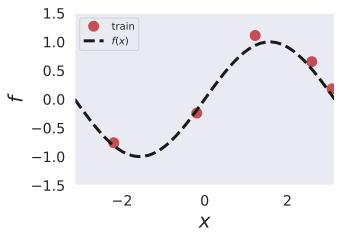

In [0]:
plot_function(train, test)
legend()
finalize_plot((0.85, 0.6))

What a good looking dataset! Let's train a neural network on it.

## Defining a Neural Network

The first thing we need to do is define a neural network. We'll start out with a simple fully-connected network using `Erf` nonlinearities. We describe our network using our neural network library that shares syntax and code with JAX's own library called [stax](https://github.com/google/jax#neural-net-building-with-stax). Layers in `jax.experimental.stax` are pairs of functions `(init_fun, apply_fun)` where `init_fun(key, input_shape)` draws parameters randomly and `apply_fun(params, xs)` computes outputs of the function for specific inputs. These layers can be composed using `serial` and `parallel` combinators to produce new `(init_fun, apply_fun)` pairs.

Similarly, layers in `neural_tangents.stax` are triplets of functions `(init_fun, apply_fun, ker_fun)` where the first two functions are the same as their `stax` equivalent but the third function, `ker_fun`, computes infinite-width GP kernels corresponding to the layer. Again these layers can be composed using `serial` and `parallel` to build kernels for complicated architectures. Fully-connected layers in `neural_tangents.stax` are created using the `Dense` layer which is defined by,
$$z^{l+1}_i = \frac{\sigma_w}{\sqrt{N_{in}}} \sum_j W_{ij} z^{l}_i + \sigma_b b_i$$
where $W_{ij}, b_i\sim\mathcal N(0,1)$ at initialization and $\sigma_w, \sigma_b$ sets the scales of the weights and biases respectively.

In [0]:
init_fun, apply_fun, ker_fun = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

apply_fun = jit(apply_fun)
ker_fun = jit(ker_fun, static_argnums=(2,))

Here the lines `apply_fun = jit(apply_fun)` and `ker_fun = jit(ker_fun, static_argnums=(2,))` use a [JAX feature](https://github.com/google/jax#compilation-with-jit) that compiles functions so that they are executed as single calls to the GPU.

Next, let's take several random draws of the parameters of the network and plot what the functions look like. 

In [0]:
prior_draws = []
for _ in range(10):
  key, net_key = random.split(key)
  _, params = init_fun(net_key, (-1, 1))
  prior_draws += [apply_fun(params, test_xs)]

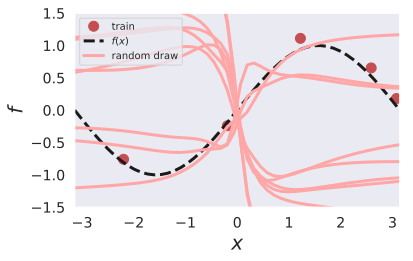

In [0]:
plot_function(train, test)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

legend(['train', '$f(x)$', 'random draw'], loc='upper left')

finalize_plot((1, 0.65))

Next we can look at the exact prior over functions in the infinite-width limit using the `ker_fun`. The kernel function has the signature `kernel = ker_fun(x_1, x_2)` which computes the kernel between two sets of inputs `x_1` and `x_2`. The `ker_fun` can compute two different kernels: the NNGP kernel which describes the Bayesian infinite network and the NT kernel which describes how this network evolves under gradient descent. We would like to visualize the standard deviation of the infinite-width function distribution at each $x$. This is given by the diagonal of the NNGP kernel. We compute this now and then plot it compared with the draws above.

In [0]:
kernel = ker_fun(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

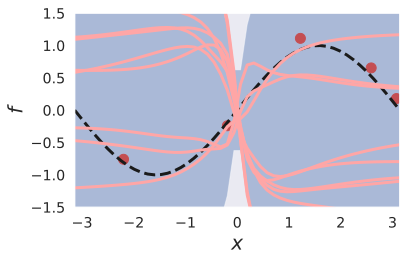

In [0]:
plot_function(train, test)

plt.fill_between(
    np.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((1, 0.65))

## Infinite Width Inference

We can use the infinite-width GP defined above to perform exact Bayesian inference using the infinite width network. To do this, we will use the function `neural_tangents.predict.gp_inference` that performs this inference exactly. `mean, var = gp_inference(ker_fun, train_xs, train_ys, test_xs)` computes the mean and variance of the network evaluated on the test points after training. The `gp_inference` function includes two different modes: in "NNGP" mode we compute the Bayesian posterior (which is equivalent to gradient descent with all but the last-layer weights frozen), in "NTK" mode we compute the distribution of networks after gradient descent training. 

We want to do exact Bayesian inference so we'll start off using the "NNGP" setting. We will compute and plot these predictions now; we will be concerned with the standard deviation of the predictions on test points which will be given by the diagonal of the covariance matrix.

In [0]:
nngp_mean, nngp_covariance = nt.predict.gp_inference(
    ker_fun, train_xs, train_ys, test_xs, 
    diag_reg=1e-4, get='nngp', compute_var=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

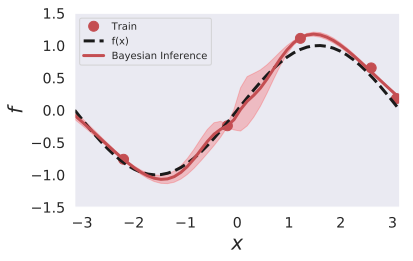

In [0]:
plot_function(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'])

finalize_plot((1, 0.65))

We see that our posterior exactly fits all of the training points as expected. We also see that the there is significant uncertainty in the predictions between the points in the middle. 

Next, we would like to compute the result of doing gradient descent on our infinite network for an *infinite* amount of time. To do this, we will use the "NTK" inference mode. Note that otherwise the call to `gp_inference` looks identical. We will compare the result of true Bayesian inference with gradient descent.

In [0]:
ntk_mean, ntk_covariance = nt.predict.gp_inference(
    ker_fun, train_xs, train_ys, test_xs, 
    diag_reg=1e-4, get='ntk', compute_var=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))

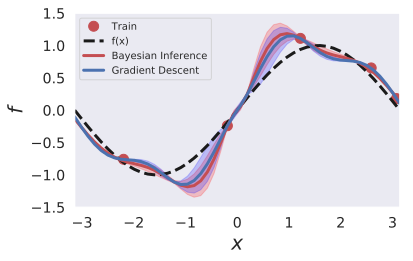

In [0]:
plot_function(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'])

finalize_plot((1, 0.65))

We see that while the result of gradient descent and bayesian inference are similar, they are not identical. 

## Training a Neural Network

We will now compare the results of gradient descent GP-inference computed above to the result of training an ensemble of finite width neural networks. We first train a single network drawn from the prior and then we will show how to generalize this to an ensemble. To do this we use JAX's gradient descent [optimizer](https://github.com/google/jax#first-order-optimization). Optimizers are described by a triple of functions `(init_fun, update_fun, get_params)`. Here, `init_fun(params)` takes an initial set of parameters and returns an optimizer state that can include extra information (like the velocity in the `momentum` optimizer). `opt_update(step, grads, state)` takes a new state and updates it using gradients. Finally, `get_params(state)` returns the parameters for a given state.  

In [0]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

Next we need to define a loss and a gradient of the loss. We'll use an MSE loss. The function `grad` is another [JAX function](https://github.com/google/jax#automatic-differentiation-with-grad) that takes a function and returns a new function that computes its gradient.

In [0]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fun(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

Now we want to actually train the network. To do this we just initialize the optimizer state and then update it however many times we want. We'll record the train and test loss after each step.


In [0]:
train_losses = []
test_losses = []

opt_state = opt_init(params)

for i in range(training_steps):
  opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses += [loss(get_params(opt_state), *train)]  
  test_losses += [loss(get_params(opt_state), *test)]

Finally, lets plot the loss over the course of training and the function after training compared with our GP inference.

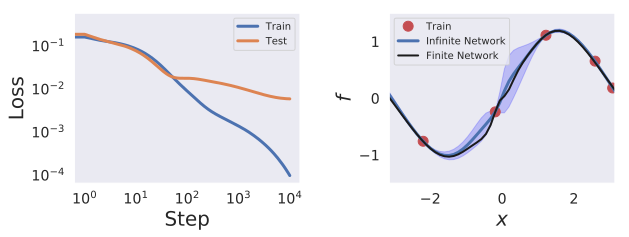

In [0]:
plt.subplot(1, 2, 1)

plt.loglog(train_losses, linewidth=3)
plt.loglog(test_losses,linewidth=3)

format_plot('Step', 'Loss')
legend(['Train', 'Test'])

plt.subplot(1, 2, 2)

plot_function(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fun(get_params(opt_state), test_xs), 'k-', linewidth=2)

legend(
    ['Train', 'Infinite Network', 'Finite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

## Training an Ensemble of Neural Networks

The draw above certainly seems consistent with exact inference. However, as discussed above to make a more quantitative comparison we want to train an ensemble of finite-width networks. To train an ensemble of networks, we're going to use another [JAX feature](https://github.com/google/jax#auto-vectorization-with-vmap) called `vmap`. `vmap` takes a function and vectorizes it over a batch dimension. In this case, we're going to add a batch dimension to our training loop so that we train a whole batch of neural networks at once. To do that, let's first wrap our whole training loop in a function. The function will take a random state and train a network based on that random state.

In [0]:
def train_network(key):
  train_losses = []
  test_losses = []

  _, params = init_fun(key, (-1, 1)) 
  opt_state = opt_init(params)

  for i in range(training_steps):
    opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

    train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]  
    test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]

  train_losses = np.concatenate(train_losses)
  test_losses = np.concatenate(test_losses)
  return get_params(opt_state), train_losses, test_losses

We can test it to make sure that we get a trained network.

In [0]:
params, train_loss, test_loss = train_network(key)

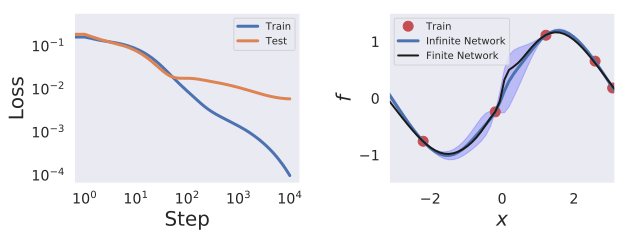

In [0]:
plt.subplot(1, 2, 1)

plt.loglog(train_losses, linewidth=3)
plt.loglog(test_losses,linewidth=3)

format_plot('Step', 'Loss')
legend(['Train', 'Test'])

plt.subplot(1, 2, 2)

plot_function(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fun(params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

Now, to train an ensemble we just have to apply `vmap` to `train_network`. The resulting function will take a vector of random states and will train one network for each random state in the vector.

In [0]:
ensemble_size = 100
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

Let's plot the empirical standard deviation in the loss over the course of training as well as well as for the function after gradient descent compared with the exact inference above. 

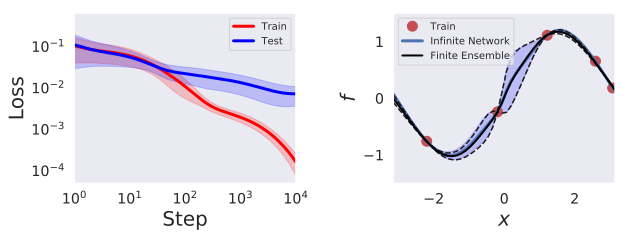

In [0]:
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
std_train_loss = np.std(train_loss, axis=0)
plt.plot(mean_train_loss, color='red', linewidth=3)
plt.fill_between(np.arange(training_steps), 
                 mean_train_loss - std_train_loss, 
                 mean_train_loss + std_train_loss,
                 color='red', alpha=0.2)

mean_test_loss = np.mean(test_loss, axis=0)
std_test_loss = np.std(test_loss, axis=0)
plt.plot(mean_test_loss, color='blue', linewidth=3)
plt.fill_between(np.arange(training_steps), 
                 mean_test_loss - std_test_loss, 
                 mean_test_loss + std_test_loss,
                 color='blue', alpha=0.2)


plt.xlim([10 ** 0, 10 ** 4])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Train', 'Test'])

plt.subplot(1, 2, 2)

plot_function(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fun, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))

We see pretty nice agreement between exact inference of the infinite-width networks and the result of training an ensemble!

## Playing Around with the Architecture

To demonstrate the ease of specifying more exotic architecture, can try to reproduce the above results with different choices of architecture. For fun, let's see what happens if we add residual connections.

In [0]:
ResBlock = stax.serial(
    stax.FanOut(2),
    stax.parallel(
        stax.serial(
            stax.Erf(),
            stax.Dense(512, W_std=1.1, b_std=0),
        ),
        stax.Identity()
    ),
    stax.FanInSum()
)

init_fun, apply_fun, ker_fun = stax.serial(
    stax.Dense(512, W_std=1, b_std=0),
    ResBlock, ResBlock, stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0)
)

apply_fun = jit(apply_fun)
ker_fun = jit(ker_fun, static_argnums=(2,))

Given this new architecture, let's train a new ensemble of models.

In [0]:
ensemble_size = 100
learning_rate = 0.1

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

key, = random.split(key, 1)
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

Finally, let's repeat our NTK-GP inference

In [0]:
ntk_mean, ntk_var = nt.predict.gp_inference(
    ker_fun, train_xs, train_ys, test_xs, 
    diag_reg=1e-4, get='NTK', compute_var=True)
ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_var))

Now let's draw the result!

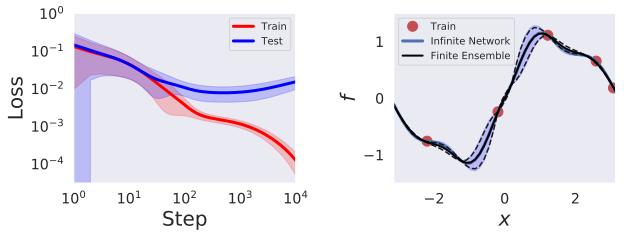

In [0]:
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
std_train_loss = np.std(train_loss, axis=0)
plt.plot(mean_train_loss, color='red', linewidth=3)
plt.fill_between(np.arange(training_steps), 
                 mean_train_loss - std_train_loss, 
                 mean_train_loss + std_train_loss,
                 color='red', alpha=0.2)

mean_test_loss = np.mean(test_loss, axis=0)
std_test_loss = np.std(test_loss, axis=0)
plt.plot(mean_test_loss, color='blue', linewidth=3)
plt.fill_between(np.arange(training_steps), 
                 mean_test_loss - std_test_loss, 
                 mean_test_loss + std_test_loss,
                 color='blue', alpha=0.2)


plt.xlim([10 ** 0, 10 ** 4])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Train', 'Test'])

plt.subplot(1, 2, 2)

plot_function(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fun, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))